# import

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import plotly.express as px
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

#  review 1. 대학원 지원  (분류)

## (1) 데이터 이해 및 정리

In [23]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Graduate_apply.csv"
data = pd.read_csv(path)
data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [24]:
target = 'admit'
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [25]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

## (2) ML  model

In [26]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)
ml_pred = model.predict(x_val)

In [27]:
print(confusion_matrix(y_val, ml_pred))
print('-'*50)
print(classification_report(y_val, ml_pred))

[[48  7]
 [18  7]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.87      0.79        55
           1       0.50      0.28      0.36        25

    accuracy                           0.69        80
   macro avg       0.61      0.58      0.58        80
weighted avg       0.66      0.69      0.66        80



## (3) DL model

### 1) 전처리

In [28]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)

### 2) 모델링

In [29]:
nf = x_train.shape[1]

`-` 현재 이거는 `ouput layer` 하나만 만든 것임

* 또한, 분류 모델링이므로 `ouput layer`에 활성화 함수로 `sigmoid` 함수를 사용

In [30]:
d_model = Sequential(Dense(1,input_shape = (nf,), activation = "sigmoid"))

d_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
d_model.compile( optimizer = Adam(learning_rate = 0.01), loss = 'binary_crossentropy')

`-` fit & predict

In [32]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [33]:
with tf.device("/device:GPU:0") :
         d_model.fit(x_train, y_train, epochs = 50, validation_split = 0.2, verbose = 0)

In [34]:
dl_pred = d_model.predict (x_val)

dl_pred = np.where(dl_pred>= 0.5, 1, 0)

3/3 [==============================] - 0s 3ms/step


In [35]:
print(classification_report(dl_pred.reshape(-1), y_val))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82        75
           1       0.12      0.60      0.20         5

    accuracy                           0.70        80
   macro avg       0.54      0.65      0.51        80
weighted avg       0.91      0.70      0.78        80



***

# 잡담 : gpu

`-` cpu vs gpu 성능차이

`-` 그리고 디폴트로 tensorflow 모델링이 gpu를 사용하는지.....

In [36]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
4.848902251000254
GPU (s):
0.08844268399843713
GPU speedup over CPU: 54x


`-` 무려 **54**배나 차이가 나며 따로 gpu설정을 안 했는데도 알아서 gpu를 잘 쓴다...

***

# ex 1. 타이타닉 (이진 분류)

## (1) 데이터 이해 및 정리

In [37]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/titanic.3.csv"
data = pd.read_csv(path)
data.drop(['Age_scale1', 'AgeGroup', 'SibSp','Parch' ], axis = 1, inplace = True)
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,2
4,0,3,male,35.0,8.0500,S,1


`-` x,y 분리

In [38]:
target = 'Survived'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

`-` 가변수화

In [41]:
cat_cols = ['Pclass','Sex', 'Embarked']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

`-` 데이터셋 분할

In [43]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 20)

In [45]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## (2) 모델링

### 1) 전체 feature + 은닉층 x

In [54]:
nf = x_train.shape[1]

In [56]:
model1 = Sequential(Dense(1, input_shape = (nf,), activation = "sigmoid"))
model1.compile(optimizer = Adam(0.01), loss= tf.keras.losses.BinaryCrossentropy())

model1.fit(x_train, y_train,
                    epochs = 50, validation_split=0.2, verbose = 0)

In [67]:
model1_pred = np.where(model1.predict(x_val)>=0.5, 1,  0).reshape(-1)

9/9 [==============================] - 0s 3ms/step


### 2) 전체 feature + 은닉층 1개 추가

In [69]:
model2 = Sequential(Dense(16, input_shape = (nf,), activation = "relu"))

model2.add(Dense(1, activation = "sigmoid"))
model2.compile(optimizer = Adam(0.01), loss= tf.keras.losses.BinaryCrossentropy())
model2.fit(x_train, y_train,
                    epochs = 50, validation_split=0.2, verbose = 0)

In [70]:
model2_pred = np.where(model2.predict(x_val)>=0.5, 1,  0).reshape(-1)

9/9 [==============================] - 0s 2ms/step


### 3) 전체 feature +  은닉층 2개

In [73]:
model3 = Sequential(Dense(16, input_shape = (nf,), activation = "relu"))
model3.add(Dense(8, activation  = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

model3.compile(optimizer = Adam(0.01), loss= tf.keras.losses.BinaryCrossentropy())
model3.fit(x_train, y_train,
                    epochs = 50, validation_split=0.2, verbose = 0)

In [74]:
model3_pred = np.where(model3.predict(x_val)>=0.5, 1,  0).reshape(-1)

9/9 [==============================] - 0s 2ms/step


### 4) summary (모델 비교)

In [77]:
model3.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 16)                144       
                                                                 
 dense_29 (Dense)            (None, 8)                 136       
                                                                 
 dense_30 (Dense)            (None, 1)                 9         
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


||변수 개수|은닉층 수|층별 output|파라미터 수|
|:---:|:---:|:---:|:---:|:---:|
|model1|8|0|1|(8 +1) = **9**|
|model2|8|1|(16, 1)| (8 x 16 +16) + (16 x 1 + 1)  = (144 + 17)  = **163**|
|model3|8|2|(16, 8 ,1)| (8 x 16 +16) + (16 x 8 + 8)   +  (8 x 1 + 1) = (144 + 136 + 9)  = **289**|


In [85]:
h1 = pd.DataFrame(model1.fit(x_train, y_train,
                    epochs = 50, validation_split=0.2, verbose = 0).history)
h2 = pd.DataFrame(model2.fit(x_train, y_train,
                    epochs = 50, validation_split=0.2, verbose = 0).history)
h3 = pd.DataFrame(model3.fit(x_train, y_train,
                    epochs = 50, validation_split=0.2, verbose = 0).history)

`-` 비교를 위해 결과를 합침

In [92]:
["a"*3,"b","c"]

['aaa', 'b', 'c']

In [98]:
temp = ["model1", "model2", "model3"]*50
temp.sort()

||변수 개수|은닉층 수|층별 output|activation|파라미터 수|
|:---:|:---:|:---:|:---:|:---:|:---:|
|model1|8|0|1|sigmoid|(8 +1) = **9**|
|model2|8|1|(16, 1)|relu, sigmoid| (8 x 16 +16) + (16 x 1 + 1)  = (144 + 17)  = **163**|
|model3|8|2|(16, 8 ,1)|relu, relu, sigmoid|(8 x 16 +16) + (16 x 8 + 8)   +  (8 x 1 + 1) = (144 + 136 + 9)  = **289**|


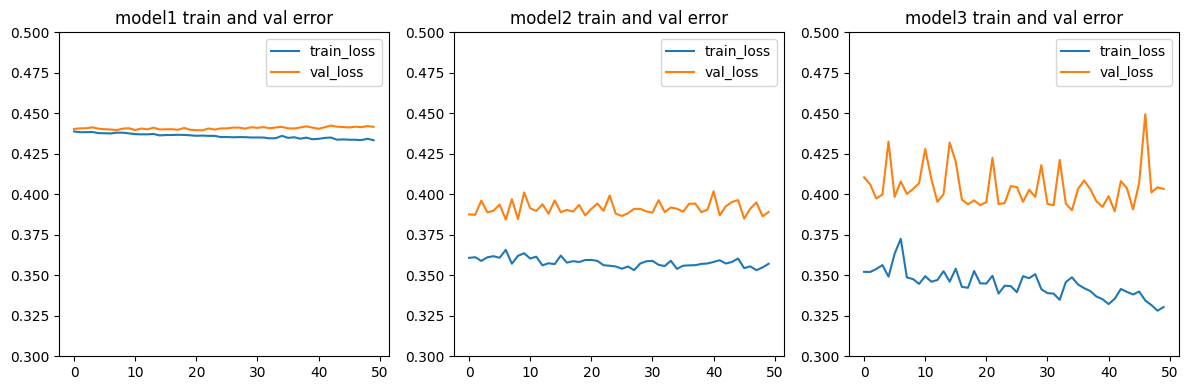

In [117]:
#| code-fold : true
fig,axes = plt.subplots(1,3, figsize = (12, 4))

ax1, ax2, ax3 = axes

ax1.plot(h1["loss"],label = "train_loss")
ax1.plot(h1["val_loss"],label = "val_loss")
ax1.set_title("model1 train and val error")
ax1.legend()
ax1.set_ylim(0.3, 0.5)

ax2.plot(h2["loss"],label = "train_loss")
ax2.plot(h2["val_loss"],label = "val_loss")
ax2.set_title("model2 train and val error")
ax2.legend()
ax2.set_ylim(0.3, 0.5)


ax3.plot(h3["loss"],label = "train_loss")
ax3.plot(h3["val_loss"],label = "val_loss")
ax3.set_title("model3 train and val error")
ax3.legend()
ax3.set_ylim(0.3, 0.5)

fig.tight_layout()
plt.show()

`-` 루프로 구현

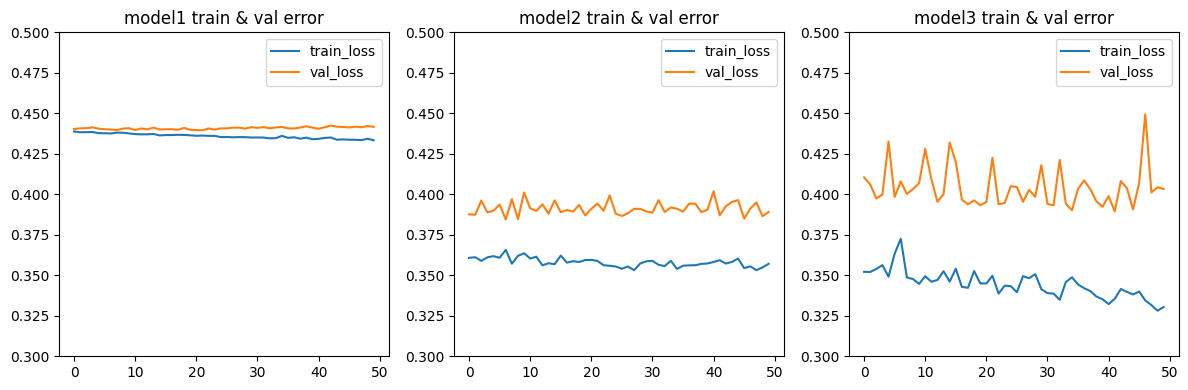

In [120]:
#| code-fold : true
fig,axes = plt.subplots(1,3, figsize = (12, 4))

ax1, ax2, ax3 = axes

for i in range(1,4) :
       exec(f'ax{i}.plot(h{i}["loss"],label = "train_loss")')
       exec(f'ax{i}.plot(h{i}["val_loss"],label = "val_loss")')
       exec(f'ax{i}.set_title("model{i} train & val error")')
       exec(f"ax{i}.legend()")
       exec(f"ax{i}.set_ylim(0.3, 0.5)")

fig.tight_layout()
plt.show()

`-` 예측 성능 비교

In [112]:
print(np.mean(y_val == model1_pred))
print(np.mean(y_val == model2_pred))
print(np.mean(y_val == model3_pred))

0.7723880597014925
0.7835820895522388
0.7873134328358209


***

# ex2. 이직 예측 (이진 분류)

## (1) 데이터 이해 및 준비

In [122]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition_train_validation.CSV"
data = pd.read_csv(path)
data['Attrition'] = np.where(data['Attrition']=='Yes', 1, 0)
data.head(5)

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager
0,0,33,Travel_Rarely,Research & Development,7,3,Medical,817,3,Male,...,No,11,4,0,14,3,4,13,9,7
1,0,35,Travel_Frequently,Research & Development,18,2,Life Sciences,1412,3,Male,...,No,11,3,0,10,2,3,2,2,2
2,0,42,Travel_Rarely,Research & Development,6,3,Medical,1911,3,Male,...,No,13,2,1,18,3,4,13,7,7
3,0,46,Travel_Rarely,Sales,2,3,Marketing,1204,3,Female,...,No,23,1,0,28,2,3,26,15,9
4,0,39,Travel_Frequently,Sales,20,3,Life Sciences,1812,3,Male,...,No,18,4,1,7,6,3,2,1,2


In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Attrition                 1250 non-null   int64 
 1   Age                       1250 non-null   int64 
 2   BusinessTravel            1250 non-null   object
 3   Department                1250 non-null   object
 4   DistanceFromHome          1250 non-null   int64 
 5   Education                 1250 non-null   int64 
 6   EducationField            1250 non-null   object
 7   EmployeeNumber            1250 non-null   int64 
 8   EnvironmentSatisfaction   1250 non-null   int64 
 9   Gender                    1250 non-null   object
 10  JobInvolvement            1250 non-null   int64 
 11  JobRole                   1250 non-null   object
 12  JobSatisfaction           1250 non-null   int64 
 13  MaritalStatus             1250 non-null   object
 14  MonthlyIncome           

`-` x,y 분리

In [125]:
target = "Attrition"

data.drop("EmployeeNumber", axis = 1, inplace =True)

In [126]:
x = data.drop(target, axis = 1)
y = data[target]

`-` 가변수화

In [128]:
dum_cols = ['BusinessTravel','Department','Education','EducationField','EnvironmentSatisfaction','Gender',
            'JobRole', 'JobInvolvement', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'RelationshipSatisfaction',
            'StockOptionLevel','WorkLifeBalance' ]
x = pd.get_dummies(x, columns = dum_cols ,drop_first = True)
x.head()

,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,...,OverTime_Yes,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,33,7,11691,0,11,14,3,13,9,7,...,0,0,0,1,0,0,0,0,0,1
1,35,18,9362,2,11,10,2,2,2,2,...,0,0,1,0,0,0,0,0,1,0
2,42,6,13348,9,13,18,3,13,7,7,...,0,1,0,0,1,0,0,0,0,1
3,46,2,17048,8,23,28,2,26,15,9,...,0,0,0,0,0,0,0,0,1,0
4,39,20,4127,2,18,7,6,2,1,2,...,0,0,0,1,1,0,0,0,1,0


`-` 데이터셋 분할

In [129]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 200, random_state = 2022)

`-` 스케일링

In [130]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## (2) 모델링

`-` 아래와 같이 3개의 모델을 만들자.

||변수 개수|은닉층 수|층별 output|activation|
|:---:|:---:|:---:|:---:|:---:|
|model1|53|0|1|sigmoid|
|model2|53|1|(16, 1)|relu, sigmoid|
|model3|53|2|(16, 8 ,1)|relu, relu, sigmoid|

In [133]:
nf = x_train.shape[1]
nf

53

`=` 모델 셋팅

In [137]:
# model1
model1 = Sequential()
model1.add(Dense(1, input_shape = (nf,), activation = "sigmoid"))
model1.compile(optimizer = Adam(0.01), loss = tf.keras.losses.BinaryCrossentropy())

# model2
model2 = Sequential()
model2.add(Dense(16, input_shape = (nf,), activation = "relu"))
model2.add(Dense(1, input_shape = (nf,), activation = "sigmoid"))
model2.compile(optimizer = Adam(0.01), loss = tf.keras.losses.BinaryCrossentropy())

# model2
model3 = Sequential()
model3.add(Dense(16, input_shape = (nf,), activation = "relu"))
model3.add(Dense(8, input_shape = (nf,), activation = "relu"))
model3.add(Dense(1, input_shape = (nf,), activation = "sigmoid"))
model3.compile(optimizer = Adam(0.01), loss = tf.keras.losses.BinaryCrossentropy())

`-` 모댈 fit

In [144]:
for i in range(1,4) :
       exec(f"h{i} = pd.DataFrame(model{i}.fit(x_train, y_train, epochs = 50, validation_split = 0.2,  verbose = 0).history)")
       exec(f"h{i}['epochs'] = list(range(1,51))")

In [147]:
h1["model"] = "model1"
h2["model"] = "model2"
h3["model"] = "model3"

`-` train, val error 시각화

||변수 개수|은닉층 수|층별 output|activation|
|:---:|:---:|:---:|:---:|:---:|
|model1|53|0|1|sigmoid|
|model2|53|1|(16, 1)|relu, sigmoid|
|model3|53|2|(16, 8 ,1)|relu, relu, sigmoid|

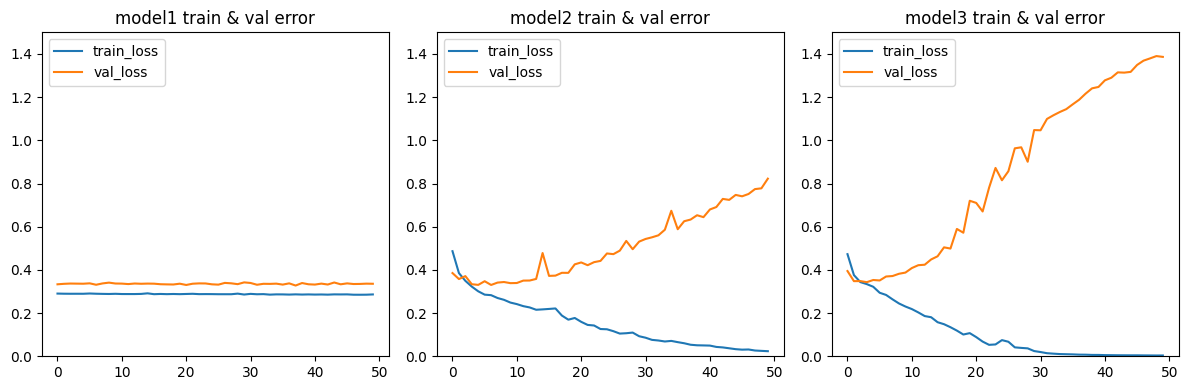

In [189]:
#| code-fold : true
fig, axes = plt.subplots(1,3, figsize = (12, 4))

ax1, ax2, ax3 = axes

for i in range(1,4) :
      exec(f"ax{i}.plot(h{i}['loss'],label = 'train_loss')")
      exec(f"ax{i}.plot(h{i}['val_loss'],label = 'val_loss')")
      exec(f"ax{i}.legend(loc = 'upper left')")
      exec(f"ax{i}.set_title('model{i} train & val error')")
      exec(f"ax{i}.set_ylim(0,1.5)")
fig.tight_layout()
fig.show()

`-` test error 시각화

In [172]:
for i in range(1,4) :
    exec(f"p{i} = np.where(model{i}.predict(x_val)>= 0.5 , 1, 0).reshape(-1)")

7/7 [==============================] - 0s 3ms/step


In [175]:
model = ["model1", "model2", "model3"]
acc1 = [np.mean(y_val == p1),np.mean(y_val == p2),np.mean(y_val == p3)]
pre = [precision_score(y_val, p1), precision_score(y_val, p2),precision_score(y_val, p3)]
re = [recall_score(y_val, p1), recall_score(y_val, p2),recall_score(y_val, p3)]
f1= [f1_score(y_val, p1), f1_score(y_val, p2),f1_score(y_val, p3)]

In [190]:
#| code-fold : true
pd.DataFrame({"model" : model,
                            "acc" : acc1,
                            "precision" : pre,
                            "recall" : re,
                            "f1_score" : f1}).melt(id_vars = "model",
                                                                  var_name = "measure").plot(x  = "measure", y = "value", facet_col = "model",
                                                                                                                    kind = "bar", backend = "plotly", color = "measure", text_auto = True)